# Task 3

# Imports

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})
## add any other additional packages that you need. You are free to use any packages for vizualization.

## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

In [2]:
## Depending on the permissions that you provided to your bucket you might need to provide your aws credentials
## to read from the bucket, if so provide with your credentials and pass as storage_options=aws_credentials
# aws_credentials = {"key": "","secret": "","token":""}
df = pd.read_csv("ml_data_SYD.csv", index_col=0, parse_dates=True)

In [66]:
# 1. Drop rows with nans
df = df.dropna(axis=0, how='any')
df = df.sort_index(ascending=True)

In [87]:
# 2. split into train and test
target_col = 'observed_rainfall'
train, test = train_test_split(df, test_size=0.2, random_state=123, shuffle=False)

# Set the target variable from the rest of the features

Text(0, 0.5, 'Count')

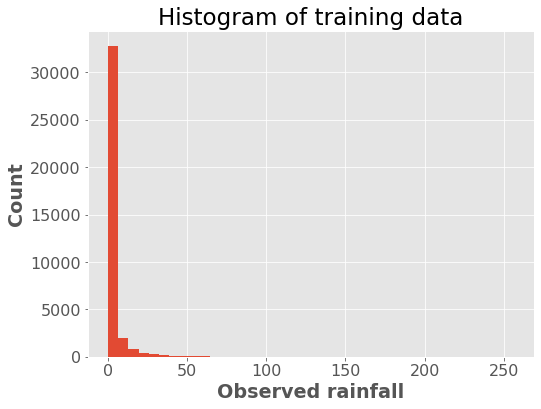

In [88]:
train[target_col].hist(bins=40)
plt.title("Histogram of training data")
plt.xlabel("Observed rainfall")
plt.ylabel("Count")

Text(0, 0.5, 'Rainfall in mm')

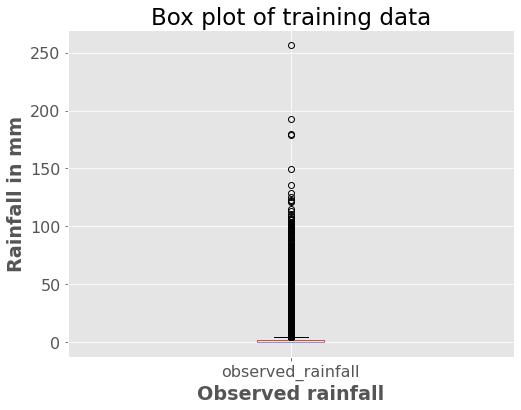

In [89]:
pd.DataFrame(train[target_col]).boxplot(column=target_col).plot(title = 'Rainfall < 1mm')
plt.title("Box plot of training data")
plt.xlabel("Observed rainfall")
plt.ylabel("Rainfall in mm")

In [90]:
# Split into X and y
X_cols = [col for col in train.columns if col != target_col]
X_train, y_train = train[X_cols], train[target_col]
X_test, y_test = test[X_cols], test[target_col]

In [96]:
# 4. Fit a Random Forest Regressor and tune the model

from collections import defaultdict

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

results = defaultdict(dict)

model_pipeline = Pipeline(steps=[('fit', RandomForestRegressor(random_state=123))])

param_dist = {"fit__n_estimators": [ 100,],
              "fit__max_depth": [ 3,],
              }

cv_model = RandomizedSearchCV(model_pipeline, param_dist,
                        cv=5,
                        return_train_score=True,
                        scoring='neg_root_mean_squared_error' )

solution_space = cv_model.fit(X_train, y_train)

print("Best parameters: ",solution_space.best_params_)
print("Best Score: ",solution_space.best_score_)

best_predictor_model = cv_model.best_estimator_.named_steps['fit']
best_predictor_model

/Users/bulut/miniconda3/envs/574/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
best_model = best_predictor_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)

predicted_values = pd.DataFrame([y_train.tolist(), y_pred]).T
predicted_values.columns = ['Actual','Predicted']
predicted_values.plot(x="Actual", y="Predicted",
                      kind="scatter",figsize=(12,6),
                      title='Actual vs Predicted')

## Part 2:

### Preparation for deploying model next week

***NOTE: Complete task 4 from the milestone3 before coming here***

We’ve found the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [ ]:
model = RandomForestRegressor(n_estimators=___, max_depth=___)
model.fit(X_train, y_train)

In [ ]:
print(f"Train RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

In [28]:
# ready to deploy
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3 under output folder. You choose how you want to upload it (using CLI, SDK, or web console).***